In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm


Sets training configurations and loads the ProstateX labels. It ensures only patients with
corresponding preprocessed .npy volume files are included in the dataset.

In [42]:

# === Config ===
DATA_DIR = r"C:\Users\anude\Downloads\processed_data"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
BATCH_SIZE = 4
EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load labels and volume paths ===
df = pd.read_csv(FINDINGS_CSV)
df = df.dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str)
df['ClinSig'] = df['ClinSig'].astype(int)

# Only use IDs that have .npy files
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]


In [43]:
#Functions

def resize_volume(vol, target_shape=(3, 64, 64, 64)):
    """
    Resizes a 4D volume by cropping or zero-padding to match the target shape.
    Ensures consistent input dimensions for model training.
    """
    c, d, h, w = vol.shape
    tc, td, th, tw = target_shape
    padded = np.zeros(target_shape, dtype=np.float32)
    
    # Crop if too big
    d = min(d, td)
    h = min(h, th)
    w = min(w, tw)

    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded

def load_tensor_dataset(dataframe, target_shape=(3, 64, 64, 64)):
    """
    Loads and resizes volumes from .npy files, stacks them into tensors,
    and returns a TensorDataset of image volumes and binary labels.
    """
    x_list, y_list = [], []
    for _, row in dataframe.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            vol = resize_volume(vol, target_shape)
            x_list.append(vol)
            y_list.append(row['ClinSig'])
        except Exception as e:
            print(f"[ERROR] Skipping {row['ProxID']}: {e}")
    x_tensor = torch.tensor(np.stack(x_list))  # [N, 3, 64, 64, 64]
    y_tensor = torch.tensor(y_list, dtype=torch.float32)
    return TensorDataset(x_tensor, y_tensor)


Splits the dataset into stratified training and validation sets based on ClinSig, loads them as tensor datasets, and prepares PyTorch DataLoaders for model training and evaluation.

In [45]:
# Split into train/val
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)

train_data = load_tensor_dataset(train_df)
val_data = load_tensor_dataset(val_df)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

A simple 3D CNN for binary classification of prostate lesions is trained using binary cross-entropy loss. After each epoch, the training loss is printed, and the model learns to predict clinical significance from the preprocessed 3D volumes.

In [47]:
# === Define model ===
model = nn.Sequential(
    nn.Conv3d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Flatten(),
    nn.Linear(32 * 16 * 16 * 16, 128),  # adjust if input shape is different
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(DEVICE)

# === Training ===
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.BCELoss()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x_batch).squeeze()
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

# === Save model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\prostate_cnn_model_3d.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f" Model saved to {MODEL_PATH}")


Epoch 1/10: 100%|██████████| 29/29 [00:00<00:00, 42.81it/s]


Epoch 1 - Loss: 14.6193


Epoch 2/10: 100%|██████████| 29/29 [00:00<00:00, 45.72it/s]


Epoch 2 - Loss: 14.5370


Epoch 3/10: 100%|██████████| 29/29 [00:00<00:00, 43.89it/s]


Epoch 3 - Loss: 14.7501


Epoch 4/10: 100%|██████████| 29/29 [00:00<00:00, 44.26it/s]


Epoch 4 - Loss: 13.8952


Epoch 5/10: 100%|██████████| 29/29 [00:00<00:00, 45.42it/s]


Epoch 5 - Loss: 13.7991


Epoch 6/10: 100%|██████████| 29/29 [00:00<00:00, 47.37it/s]


Epoch 6 - Loss: 13.1218


Epoch 7/10: 100%|██████████| 29/29 [00:00<00:00, 47.78it/s]


Epoch 7 - Loss: 12.7761


Epoch 8/10: 100%|██████████| 29/29 [00:00<00:00, 47.41it/s]


Epoch 8 - Loss: 11.8796


Epoch 9/10: 100%|██████████| 29/29 [00:00<00:00, 47.64it/s]


Epoch 9 - Loss: 11.3707


Epoch 10/10: 100%|██████████| 29/29 [00:00<00:00, 47.48it/s]

Epoch 10 - Loss: 10.8311
 Model saved to C:\Users\anude\Downloads\project\prostate_cnn_model_3d.pth


Loads the saved 3D CNN model and evaluates its predictions on the validation set, calculating classification metrics like precision, recall, and F1-score for ClinSig and non-ClinSig cases.

In [49]:
# === Load saved model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\prostate_cnn_model_3d.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# === Evaluation ===
all_preds, all_labels = [], []
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        preds = model(x_batch).squeeze().cpu().numpy()
        preds = (preds > 0.5).astype(int)
        all_preds += [int(preds)] if np.isscalar(preds) else preds.tolist()
        all_labels += [int(y_batch)] if torch.numel(y_batch) == 1 else y_batch.numpy().tolist()

print("\n Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Not ClinSig", "ClinSig"]))



 Evaluation Report:
              precision    recall  f1-score   support

 Not ClinSig       0.78      0.91      0.84        23
     ClinSig       0.00      0.00      0.00         6

    accuracy                           0.72        29
   macro avg       0.39      0.46      0.42        29
weighted avg       0.62      0.72      0.67        29



Visualises the confusion matrix to assess how well the model distinguishes between clinically significant and non-significant lesions.

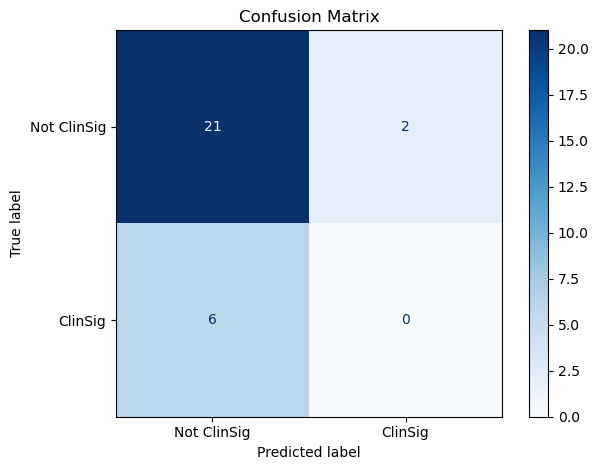

In [51]:
# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


<h2> Improving the accuracy and precision

Adding focal loss, data augmentation, and oversampling of clinically significant cases to handle class imbalance. It uses a deeper CNN architecture with batch normalization, dropout, and a learning rate scheduler for better generalisation

In [5]:

DATA_DIR = r"C:\Users\anude\Downloads\processed_data"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
BATCH_SIZE = 4
EPOCHS = 30
LR = 1e-4
GAMMA = 3.0
THRESHOLD = 0.5
TARGET_SHAPE = (3, 64, 64, 64)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Focal Loss ===
def focal_loss(logits, targets, gamma=GAMMA):
    """
    Computes Focal Loss to address class imbalance by focusing more on hard-to-classify examples.
    """
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    pt = torch.exp(-bce)
    return ((1 - pt) ** gamma * bce).mean()

# === Augmentation ===
def augment(volume):
    """
    Applies random 3D augmentations to a volume: horizontal flip, vertical flip, and 90-degree rotations.
    """
    if random.random() < 0.5:
        volume = np.flip(volume, axis=2)  # Horizontal
    if random.random() < 0.5:
        volume = np.flip(volume, axis=3)  # Vertical
    if random.random() < 0.5:
        k = random.choice([1, 2, 3])
        volume = np.rot90(volume, k, axes=(2, 3)).copy()
    return volume

# === Resize + optional augment ===
def resize_volume(vol, target_shape, augment_flag=False):
    """
    Resizes a volume to the target shape by cropping or zero-padding, with optional augmentation.
    """
    if augment_flag:
        vol = augment(vol)
    c, d, h, w = vol.shape
    tc, td, th, tw = target_shape
    padded = np.zeros(target_shape, dtype=np.float32)
    d, h, w = min(d, td), min(h, th), min(w, tw)
    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded

# === Data loader with augment for ClinSig ===
def load_tensor_dataset(df, shape=TARGET_SHAPE, augment_clinsig=False):
    """
    Loads volume data and labels into a TensorDataset, applying augmentation only to ClinSig-positive samples.
    Returns the dataset and associated patient IDs.
    """
    x_list, y_list, ids = [], [], []
    for _, row in df.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            is_clinsig = row['ClinSig'] == 1
            vol = resize_volume(vol, shape, augment_flag=augment_clinsig and is_clinsig)
            x_list.append(vol)
            y_list.append(row['ClinSig'])
            ids.append(row['ProxID'])
        except Exception as e:
            print(f"[ERROR] Skipping {row['ProxID']}: {e}")
    x_tensor = torch.tensor(np.stack(x_list))
    y_tensor = torch.tensor(y_list, dtype=torch.float32)
    return TensorDataset(x_tensor, y_tensor), ids

In [7]:

# === Data prep ===
df = pd.read_csv(FINDINGS_CSV)
df = df.dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str)
df['ClinSig'] = df['ClinSig'].astype(int)
df['ProxID'] = df['ProxID'].apply(lambda x: x if x.startswith("ProstateX-") else f"ProstateX-{x}")
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]


In [9]:
# === Train/val split + duplicate ClinSig once ===
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)
clinsig_df = train_df[train_df['ClinSig'] == 1]
train_df = pd.concat([train_df, clinsig_df], ignore_index=True)

# === Display counts ===
print("Train class distribution:\n", train_df['ClinSig'].value_counts())
print("Val class distribution:\n", val_df['ClinSig'].value_counts())

# === Load Datasets ===
train_data, _ = load_tensor_dataset(train_df, augment_clinsig=True)
val_data, val_ids = load_tensor_dataset(val_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

Train class distribution:
 ClinSig
0    94
1    44
Name: count, dtype: int64
Val class distribution:
 ClinSig
0    23
1     6
Name: count, dtype: int64


A deep 3D CNN with batch normalization, dropout, and LeakyReLU activations, then trains it using focal loss and a learning rate scheduler. The model is optimised to handle class imbalance and learn robust features from volumetric prostate data.

In [10]:
# === Deep CNN Model ===
model = nn.Sequential(
    nn.Conv3d(3, 16, 3, padding=1), nn.BatchNorm3d(16), nn.LeakyReLU(),
    nn.Conv3d(16, 32, 3, padding=1), nn.BatchNorm3d(32), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(64 * 16 * 16 * 16, 256), nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1)
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# === Training Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x_batch).squeeze()
        loss = focal_loss(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")
    scheduler.step(total_loss)

# === Save Trained Model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\prostate_cnn_model_3DCNN.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f" Model saved to {MODEL_PATH}")




Epoch 1/30: 100%|██████████| 35/35 [00:06<00:00,  5.65it/s]


Epoch 1 - Loss: 81.6075


Epoch 2/30: 100%|██████████| 35/35 [00:03<00:00, 11.44it/s]


Epoch 2 - Loss: 35.8699


Epoch 3/30: 100%|██████████| 35/35 [00:03<00:00, 11.43it/s]


Epoch 3 - Loss: 18.0714


Epoch 4/30: 100%|██████████| 35/35 [00:03<00:00, 11.47it/s]


Epoch 4 - Loss: 11.0607


Epoch 5/30: 100%|██████████| 35/35 [00:03<00:00, 11.43it/s]


Epoch 5 - Loss: 10.0713


Epoch 6/30: 100%|██████████| 35/35 [00:03<00:00, 11.41it/s]


Epoch 6 - Loss: 7.9680


Epoch 7/30: 100%|██████████| 35/35 [00:03<00:00, 11.16it/s]


Epoch 7 - Loss: 9.5732


Epoch 8/30: 100%|██████████| 35/35 [00:03<00:00, 11.26it/s]


Epoch 8 - Loss: 4.1517


Epoch 9/30: 100%|██████████| 35/35 [00:03<00:00, 11.37it/s]


Epoch 9 - Loss: 7.9195


Epoch 10/30: 100%|██████████| 35/35 [00:03<00:00, 11.27it/s]


Epoch 10 - Loss: 6.4413


Epoch 11/30: 100%|██████████| 35/35 [00:03<00:00, 11.37it/s]


Epoch 11 - Loss: 2.6241


Epoch 12/30: 100%|██████████| 35/35 [00:03<00:00, 11.29it/s]


Epoch 12 - Loss: 7.4335


Epoch 13/30: 100%|██████████| 35/35 [00:03<00:00, 11.29it/s]


Epoch 13 - Loss: 3.0191


Epoch 14/30: 100%|██████████| 35/35 [00:03<00:00, 11.24it/s]


Epoch 14 - Loss: 4.3817


Epoch 15/30: 100%|██████████| 35/35 [00:03<00:00, 11.19it/s]


Epoch 15 - Loss: 2.0139


Epoch 16/30: 100%|██████████| 35/35 [00:03<00:00, 11.13it/s]


Epoch 16 - Loss: 1.4824


Epoch 17/30: 100%|██████████| 35/35 [00:03<00:00, 11.23it/s]


Epoch 17 - Loss: 1.0660


Epoch 18/30: 100%|██████████| 35/35 [00:03<00:00, 11.20it/s]


Epoch 18 - Loss: 3.0928


Epoch 19/30: 100%|██████████| 35/35 [00:03<00:00, 11.23it/s]


Epoch 19 - Loss: 2.0996


Epoch 20/30: 100%|██████████| 35/35 [00:03<00:00, 11.26it/s]


Epoch 20 - Loss: 0.9305


Epoch 21/30: 100%|██████████| 35/35 [00:03<00:00, 11.29it/s]


Epoch 21 - Loss: 1.5118


Epoch 22/30: 100%|██████████| 35/35 [00:03<00:00, 11.29it/s]


Epoch 22 - Loss: 0.7506


Epoch 23/30: 100%|██████████| 35/35 [00:03<00:00, 11.28it/s]


Epoch 23 - Loss: 0.9565


Epoch 24/30: 100%|██████████| 35/35 [00:03<00:00, 11.33it/s]


Epoch 24 - Loss: 2.0987


Epoch 25/30: 100%|██████████| 35/35 [00:03<00:00, 11.22it/s]


Epoch 25 - Loss: 0.8172


Epoch 26/30: 100%|██████████| 35/35 [00:03<00:00, 11.28it/s]


Epoch 26 - Loss: 1.5202


Epoch 27/30: 100%|██████████| 35/35 [00:03<00:00, 11.25it/s]


Epoch 27 - Loss: 1.4276


Epoch 28/30: 100%|██████████| 35/35 [00:03<00:00, 11.29it/s]


Epoch 28 - Loss: 0.8357


Epoch 29/30: 100%|██████████| 35/35 [00:03<00:00, 11.34it/s]


Epoch 29 - Loss: 0.4301


Epoch 30/30: 100%|██████████| 35/35 [00:03<00:00, 11.39it/s]


Epoch 30 - Loss: 0.5955
 Model saved to C:\Users\anude\Downloads\project\prostate_cnn_model_3DCNN.pth


Evaluates the model on the validation set using sigmoid-based thresholding and prints a classification report, displays example predictions.


 Final Evaluation Report:
              precision    recall  f1-score   support

 Not ClinSig       0.78      0.78      0.78        23
     ClinSig       0.17      0.17      0.17         6

    accuracy                           0.66        29
   macro avg       0.47      0.47      0.47        29
weighted avg       0.66      0.66      0.66        29


 Sample Predictions:
ProstateX-0026: Predicted=1, Actual=1
ProstateX-0045: Predicted=0, Actual=0
ProstateX-0072: Predicted=0, Actual=0
ProstateX-0084: Predicted=0, Actual=0
ProstateX-0022: Predicted=1, Actual=0
ProstateX-0054: Predicted=0, Actual=0
ProstateX-0091: Predicted=1, Actual=0
ProstateX-0100: Predicted=0, Actual=0
ProstateX-0046: Predicted=1, Actual=0
ProstateX-0076: Predicted=0, Actual=0


<Figure size 500x400 with 0 Axes>

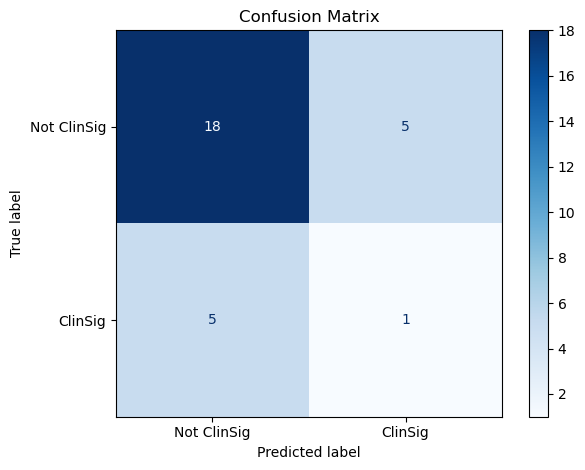

In [15]:
# === Load Saved Model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\prostate_cnn_model_3DCNN.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()


all_preds, all_labels, all_proxids = [], [], []
index = 0

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        logits = model(x_batch).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > THRESHOLD).astype(int)
        preds = np.atleast_1d(preds)
        y_batch = y_batch.numpy()
        for i in range(len(preds)):
            prox_id = val_ids[index]
            all_proxids.append(prox_id)
            all_preds.append(int(preds[i]))
            all_labels.append(int(y_batch[i]))
            index += 1

# === Report ===
print("\n Final Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Not ClinSig", "ClinSig"], zero_division=0))

print("\n Sample Predictions:")
for pid, pred, label in zip(all_proxids[:10], all_preds[:10], all_labels[:10]):
    print(f"{pid}: Predicted={pred}, Actual={label}")

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()